In [1]:
from os import walk
import os
import numpy as np
import cv2 
import matplotlib.pyplot as plt 
import shutil


In [2]:
## init_bbs = [[1,1,4,4],[1,10,6,16],[1,19,20,25]]

In [3]:
def gen_tracklet(bb_init, step=1, size=10):
    list_bbs = list()
    new_bb   = bb_init.copy()
    for i in range(size):
        x0,y0,x1,y1 = new_bb
        new_bb = [x0+step,y0, x1+step,y1]
        list_bbs.append(new_bb)
    return list_bbs

In [4]:
colors = {  'Red'     : (255,0,0),
            'Lime'    : (0,255,0),
            'Blue'    : (0,0,255),
            'Yellow'  : (255,255,0),
            'Cyan'    : (0,255,255),
            'Magenta' : (255,0,255),
         }

In [5]:
colors_alpha = {  'Red'     : (255,0,0,255),
            'Lime'    : (0,255,0,255),
            'Blue'    : (0,0,255,255),
            'Yellow'  : (255,255,0,255),
            'Cyan'    : (0,255,255,255),
            'Magenta' : (255,0,255,255),
         }


colors_alpha_t =   {'Red'     : (255,0,0,100),
                    'Lime'    : (0,255,0,100),
                    'Blue'    : (0,0,255,100),
                    'Yellow'  : (255,255,0,100),
                    'Cyan'    : (0,255,255,100),
                    'Magenta' : (255,0,255,100),
                 }

In [6]:
colors_blank = {  'blank'     : (255,255,2555,255),}

In [7]:
# colors = {  'Red' 	 : (255,0,0),
#             'Lime'	 : (0,255,0),
#             'Blue'	 : (0,0,255),
#             'Yellow' : (255,255,0),
#             'Cyan' 	 : (0,255,255),
#             'Magenta': (255,0,255),
#             'Silver' : (192,192,192),
#             'Gray'	 : (128,128,128),
#             'Maroon' : (128,0,0),
#             'Olive'	 : (128,128,0),
#             'Green'	 : (0,128,0),
#             'Purple' : (128,0,128),
#             'Teal'	 : (0,128,128),
#             'Navy'	 : (0,0,128),
#         }

In [8]:
global i_color
i_color = 0

In [9]:
def reset_color_global():
    global i_color
    i_color = 0

In [10]:
def pickup_color(colors):
    global i_color
    if i_color >= len(colors):
        i_color = 0
    keys     = list(colors.keys())
    curr_key = keys[i_color]
    i_color +=1
    return colors[curr_key]
    

In [90]:
def plot_tracklet(frame_in, 
                  colors_alpha, 
                  step=1, 
                  allTrackletsInfo=None, 
                  scale=1, 
                  thickness=3, 
                  colorBB=None, 
                  imageLess=True, 
                  imageFill=True,
                  spotlight_iBB=None):
    
    frame = frame_in.copy()
    curr_color = pickup_color(colors_alpha)
     
    flag_init = True
    
    for i, (path, bb) in enumerate(allTrackletsInfo):
        if i%step==0:

            x0,y0,x1,y1 = bb
            x0,y0,x1,y1 = int(x0),int(y0),int(x1),int(y1)
            width       = abs(x1-x0)
            lenght      = abs(y1-y0)
            x_offset    = x0*scale
            y_offset    = y0*scale

            start_point = (x_offset,       y_offset)
            end_point   = (x_offset+width, y_offset+lenght)
            
            if imageLess:
                crop_img = cv2.imread(path)
#                 crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGBA)
                if not flag_init:
                    alpha_tmp    = crop_img[:,:,3]
                    alpha_tmp.fill(spotlight_iBB)
                    crop_img[:,:,3] = alpha_tmp

                frame[y_offset:y_offset+crop_img.shape[0],x_offset:x_offset+crop_img.shape[1]] = crop_img
            
        if colorBB:
            start_point = (x_offset,       y_offset)
            end_point   = (x_offset+width, y_offset+lenght)
            color       = curr_color

#             alpha_crop = frame[y_offset:y_offset+crop_img.shape[0], x_offset:x_offset+crop_img.shape[1]]
#             alpha_crop.fill(255)
#             frame[y_offset:y_offset+crop_img.shape[0], x_offset:x_offset+crop_img.shape[1]] = alpha_crop

            if imageFill:
                cv2.rectangle(frame, start_point, end_point, color, thickness)
                    
            else:
                cv2.rectangle(frame, start_point, end_point, (255,255,255), -1)
                cv2.rectangle(frame, start_point, end_point, color, thickness)
        
        if spotlight_iBB:
            flag_init = False
                
    return frame


In [133]:
def plot_tracklet_v2(frame_in,
                     colors_alpha,
                     step=1, 
                     plotTrackletsInfo=None, 
                     allTrackletsInfo=None, 
                     scale=1, 
                     thickness=3,
                     radiusPoint=10,
                     colorBB=True, 
                     imageLess=True, 
                     trackletColorBB=True, 
                     trackletlImageLess=True,
                     trackletInFront=False,
                     trackletInFrontColorBB=False,
                     trackletBB_to_point=False,
                     spotlight_iALL=None):

    
    frame        = frame_in.copy()
    curr_color   = pickup_color(colors_alpha)
    tmp_data     = list()
    
    
    flag_init = True
    if spotlight_iALL:
        flag_init = False

    
    for i, (path, bb) in enumerate(allTrackletsInfo):
        if i%step==0:
            x0,y0,x1,y1 = bb
            x0,y0,x1,y1 = int(x0),int(y0),int(x1),int(y1)
            width       = abs(x1-x0)
            lenght      = abs(y1-y0)
            x_offset    = x0*scale
            y_offset    = y0*scale

            start_point = (x_offset,       y_offset)
            end_point   = (x_offset+width, y_offset+lenght)
            
            if imageLess:
                crop_img = cv2.imread(path)
#                 crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGBA)
                if not flag_init:
                    alpha_tmp    = crop_img[:,:,3]
                    alpha_tmp.fill(spotlight_iALL)
                    crop_img[:,:,3] = alpha_tmp

                frame[y_offset:y_offset+crop_img.shape[0],x_offset:x_offset+crop_img.shape[1]] = crop_img

                # Frame
            if colorBB:
                if not trackletBB_to_point:
                    cv2.rectangle(frame, start_point, end_point, curr_color, thickness)
                else:
                    x_c,y_c = (start_point[0]+end_point[0])/2, (start_point[1]+end_point[1])/2
                    center  = (int(x_c),int(y_c)) 
                    cv2.circle(frame, center, radius=radiusPoint, color=curr_color, thickness=-1)

        for _path, _bb in plotTrackletsInfo:
            orig   = os.path.basename(path)
            search = os.path.basename(_path)
            if orig == search:
                x0,y0,x1,y1 = _bb
                x0,y0,x1,y1 = int(x0),int(y0),int(x1),int(y1)
                _width       = abs(x1-x0)
                _lenght      = abs(y1-y0)
                _x_offset    = x0*scale
                _y_offset    = y0*scale

                _start_point = (_x_offset,       _y_offset)
                _end_point   = (_x_offset+_width, _y_offset+_lenght)

                if trackletlImageLess:
                    _crop_img = cv2.imread(_path)
#                     _crop_img = cv2.cvtColor(_crop_img, cv2.COLOR_BGR2RGB)
                    _crop_img = cv2.cvtColor(_crop_img, cv2.COLOR_BGR2RGBA)
                    frame[_y_offset:_y_offset+_crop_img.shape[0], _x_offset:_x_offset+_crop_img.shape[1]] = _crop_img

                if trackletColorBB:
                    if not trackletBB_to_point:
                        cv2.rectangle(frame, start_point, end_point, curr_color, thickness)
                    else:
                        center  = (int(x_c),int(y_c)) 
                        cv2.circle(frame, center, radius=radiusPoint, color=curr_color, thickness=-1)

#                         cv2.rectangle(frame, _start_point, _end_point, curr_color, thickness)
                tmp_data.append([_path, _start_point, _end_point, curr_color, thickness])
        
#         if spotlight_iBB:
#             flag_init = False
        
    if trackletInFront:
        for _path, _start_point, _end_point, _curr_color, _thickness in tmp_data:
            _crop_img = cv2.imread(_path)                              
#             _crop_img = cv2.cvtColor(_crop_img, cv2.COLOR_BGR2RGB)
            _crop_img = cv2.cvtColor(_crop_img, cv2.COLOR_BGR2RGBA)

            frame[_y_offset:_y_offset+_crop_img.shape[0], _x_offset:_x_offset+_crop_img.shape[1]] = _crop_img
            
            if trackletInFrontColorBB:
                cv2.rectangle(frame, _start_point, _end_point, _curr_color, _thickness)
    return frame

In [13]:
def mysort(i):
    return i[1]
    
def find_dirs(path):
    f = list()
    for (dirpath, dirnames, filenames) in walk(path):
        f.extend(dirnames)
        break
    f.sort()
    f = [ [path,i] for i in f]
    return f

def find_images(path):
    f = list()
    for (dirpath, dirnames, filenames) in walk(path):
        f.extend(filenames)
        break
    f.sort()
    f = [ [path,i] for i in f]
    return f

In [14]:
spaces = {'frame':1, 'id':1, 'bbox':4}

def split_to_dict(file_name):
    list_split  = os.path.splitext(file_name)[0].split('_')
    dict_output = dict()
    for i in ['frame', 'id','bbox']:
        if i in list_split:
            index          = list_split.index(i)
            curr_index     = list_split.index(i)+1
            num_frame      = list_split[curr_index:curr_index+spaces[i]]
            dict_output[i] = num_frame
    return dict_output

In [15]:
def split_path(tuple_path):
    curr_dict = dict()
    curr_dict = split_to_dict(tuple_path[1])
    curr_dict['path'] = tuple_path[0]
    curr_dict['name'] = tuple_path[1]
    return curr_dict 

In [16]:
from collections import defaultdict

def extract_info_tree(path_tracklets):
    general_dict = defaultdict(list)
    dirs         = find_dirs(path_tracklets)
    for i in dirs:
        path_imgs    = find_images(os.path.join(i[0],i[1]))
        for _img in path_imgs:
            tmp_dict = split_path(_img)
            general_dict[tmp_dict['id'][0]].append(tmp_dict)
    return general_dict

In [17]:
def extract_info_dir(directory):
    general_dict = defaultdict(list)
    path_imgs    = find_images(directory)
    for _img in path_imgs:
        tmp_dict = split_path(_img)
        general_dict[tmp_dict['id'][0]].append(tmp_dict)
    return general_dict

## PATHs

In [41]:
save_dpi = 300

In [49]:
path_save         = './tracklet_plot_v2/'

In [50]:
# path_tracklets    = '../dataset_prid2011/2_TrADe/A-B/A-B_000001/tau_01000/seq_00000/max_tracklet_20_tau_frameStart_00000000.avi/cropping'path_tracklets    = '../dataset_prid2011/2_TrADe/A-B/A-B_000001/tau_01000/seq_00000/max_tracklet_20_tau_frameStart_00000000.avi/cropping'
path_tracklets    = '../test_tracklet'

In [51]:
os.listdir(path_tracklets)

['00000027', '00000031', '00000035', '00000043', '00000039']

In [52]:
genDict  = extract_info_tree(path_tracklets)
len(genDict)

5

In [53]:
# img = np.ones((8192,8192,3), np.uint8)*255
# img = np.ones((2048,2048,3), np.uint8)*255
# img = np.ones((128,128,3), np.uint8)*255


# for key in list(genDict.keys())[650:750]: #ok ef80
# for key in list(genDict.keys())[1050:1150]: #ok ef80
# for key in list(genDict.keys())[1450:1480]: #ok ef80

# for key in list(genDict.keys())[1450:1550]: #ok ef20


for i in list(genDict.keys())[5750:5850]:
    src = os.path.join(path_tracklets, i)
    dst = os.path.join(pSelect_tracklets,i)
    shutil.copytree(src, dst, dirs_exist_ok=True)
    

In [54]:
genDictSelect  = extract_info_tree(path_tracklets)
len(genDictSelect)

5

# plot gallery YOLOv3

img_cropped size: (550, 2000, 4)
img_cropped: [255 255 255   0]


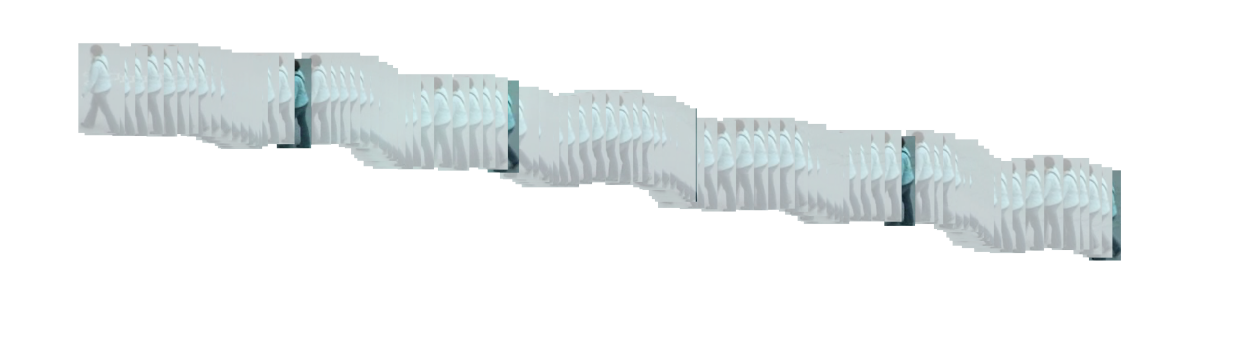

In [135]:
scale = 5
# video_shape = ((720+200)*scale, (576+200)*scale) 
video_shape = ((720)*scale, (576)*scale) 

img = np.ones((video_shape[1],video_shape[0],3), np.uint8)*255
# print(img)

img        = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
alpha      = img[:,:,3]
alpha      = alpha*0
img[:,:,3] = alpha


reset_color_global()

for key in genDictSelect: 
    
    list_dict        = genDictSelect[key]
    allTrackletsInfo = list()
    
    for i_dict in list_dict:
        allTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])
    
    img= plot_tracklet(img, 
                       colors_alpha,
                      allTrackletsInfo = allTrackletsInfo, 
                      step             = 1, 
                      scale            = scale, 
                      colorBB          = False,
                      spotlight_iBB    = 100)
    

plt.figure(figsize=(16,16))
# plt.imshow(img)




# img_cropped = img[0:2850,:, :] # Y,X,Z
img_cropped = img[650:1200,0:2000, :] # Y,X,Z
# img_cropped = img# Y,X,Z

print("img_cropped size:", img_cropped.shape)
print("img_cropped:", img_cropped[0][0])

plt.imshow(img_cropped)
# plt.title('my picture')
plt.axis('off')

plt.savefig(os.path.join(path_save,'tracklet_example.png'), dpi=save_dpi, transparent=True, bbox_inches='tight', pad_inches=0 )

plt.show()




img_cropped size: (550, 2000, 4)
img_cropped: [255 255 255   0]


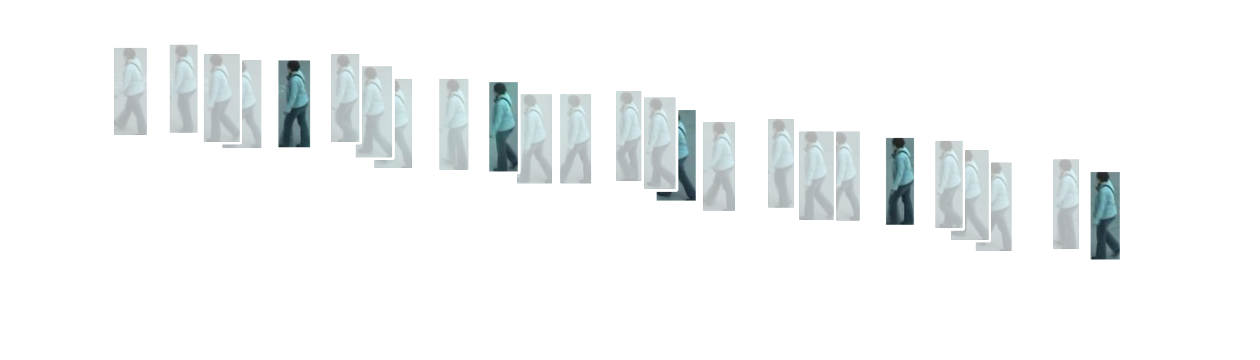

In [136]:
scale = 5
# video_shape = ((720+200)*scale, (576+200)*scale) 
video_shape = ((720)*scale, (576)*scale) 

img = np.ones((video_shape[1],video_shape[0],3), np.uint8)*255
# print(img)

img        = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
alpha      = img[:,:,3]
alpha      = alpha*0
img[:,:,3] = alpha


reset_color_global()

for key in genDictSelect: 
    
    list_dict        = genDictSelect[key]
    allTrackletsInfo = list()
    
    for i_dict in list_dict:
        allTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])
    
    img= plot_tracklet(img, 
                       colors_blank,
                      allTrackletsInfo = allTrackletsInfo, 
                      step             = 4, 
                      scale            = scale, 
                      colorBB          = True,
                      spotlight_iBB    = 90)

    

plt.figure(figsize=(16,16))
# plt.imshow(img)




img_cropped = img[650:1200,0:2000, :] # Y,X,Z
# img_cropped = img# Y,X,Z


print("img_cropped size:", img_cropped.shape)
print("img_cropped:", img_cropped[0][0])

plt.imshow(img_cropped)
# plt.title('my picture')
plt.axis('off')

plt.savefig(os.path.join(path_save,'tracklet_example_v2.png'), dpi=save_dpi, transparent=True, bbox_inches='tight', pad_inches=0 )

plt.show()




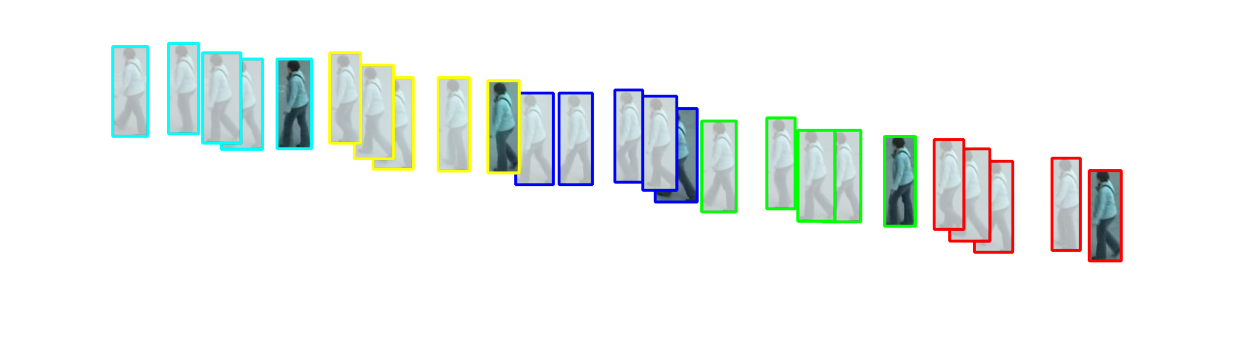

In [137]:
scale = 5
# video_shape = ((720+200)*scale, (576+200)*scale) 
video_shape = ((720)*scale, (576)*scale) 

img = np.ones((video_shape[1],video_shape[0],3), np.uint8)*255


img        = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
alpha      = img[:,:,3]
alpha      = alpha*0
img[:,:,3] = alpha


reset_color_global()

for key in genDictSelect: 
    
    list_dict        = genDictSelect[key]
    allTrackletsInfo = list()
    
    for i_dict in list_dict:
        allTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])
        
    img = plot_tracklet(img, 
                          colors_alpha,
                          allTrackletsInfo = allTrackletsInfo, 
                          step             = 4, 
                          scale            = scale, 
                          thickness        = 4,
                          colorBB          = True,
                          spotlight_iBB    = 90)



plt.figure(figsize=(16,16))
# plt.imshow(img)

img_cropped = img[650:1200,0:2000, :] # Y,X,Z
# img_cropped = img# Y,X,Z


plt.imshow(img_cropped)
# plt.title('my picture')
plt.axis('off')

plt.savefig(os.path.join(path_save,'tracklet_w_bb.png'), dpi=save_dpi, transparent=True,bbox_inches='tight', pad_inches=0)

plt.show()




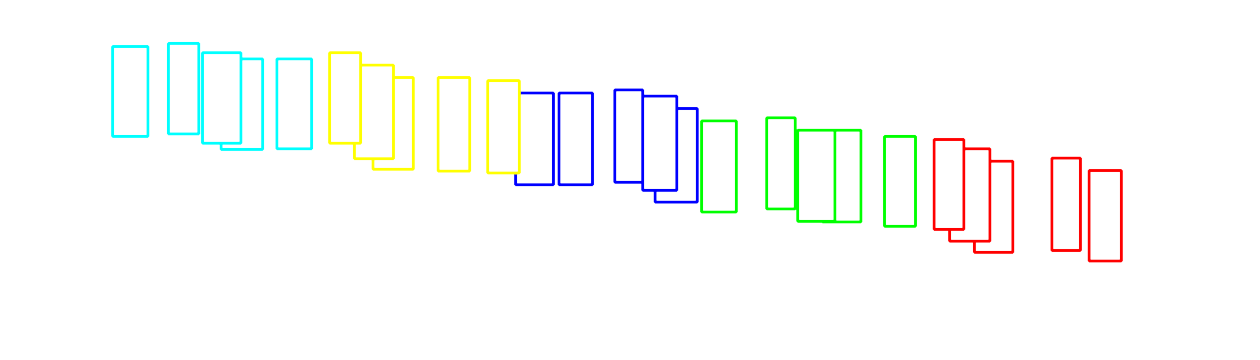

In [138]:
scale = 5
# video_shape = ((720+200)*scale, (576+200)*scale) 
video_shape = ((720)*scale, (576)*scale) 

img = np.ones((video_shape[1],video_shape[0],3), np.uint8)*255

img        = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
alpha      = img[:,:,3]
alpha      = alpha*0
img[:,:,3] = alpha

reset_color_global()

for key in genDictSelect: 
    
    list_dict        = genDictSelect[key]
    allTrackletsInfo = list()
    
    for i_dict in list_dict:
        allTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])
        
    img = plot_tracklet(img, 
                        colors_alpha,
                          allTrackletsInfo = allTrackletsInfo, 
                          step             = 4, 
                          scale            = scale,
                          thickness        = 4,
                          colorBB          = True,
                          imageLess        = False,
                          imageFill        = False)


plt.figure(figsize=(16,16))
# plt.imshow(img)

img_cropped = img[650:1200,0:2000, :] # Y,X,Z
# img_cropped = img# Y,X,Z

plt.imshow(img_cropped)
# plt.title('my picture')
plt.axis('off')

plt.savefig(os.path.join(path_save,'tracklet_only_bb.png'), dpi=save_dpi, transparent=True,bbox_inches='tight', pad_inches=0)

plt.show()




# #############################################################
# #############################################################

In [101]:
import os
from occ.interface_v2 import OneClassClassifier, create_gallery_inliers

occ               = OneClassClassifier()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-11-13 21:21:45.884291: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-13 21:21:45.952400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 21:21:45.953740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro P5000 major: 6 minor: 1 memoryClockRate(GHz): 1.506
pciBusID: 0000:01:00.0
2022-11-13 21:21:45.958217: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-13 21:21:45.958705: W tensorflow/stream_executor/platform/default/dso_loader.cc:55

In [103]:
gallery_path      = path_tracklets
savePath_bestCand = '../test_DOC_tracklet'

In [104]:
top_k_inliers = 1

for i in os.listdir(gallery_path):
    curr_g = os.path.join(gallery_path,i)
    _, path_images, _  = occ.generate_inliers_outliers(curr_g)
    shutil.copy2(path_images[0], savePath_bestCand)


2022-11-13 21:22:38.915004: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 31541760 exceeds 10% of system memory.
2022-11-13 21:22:38.991858: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 30415360 exceeds 10% of system memory.
2022-11-13 21:22:39.028362: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 60830720 exceeds 10% of system memory.
2022-11-13 21:22:39.097496: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 18662400 exceeds 10% of system memory.
2022-11-13 21:22:39.111163: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 41533440 exceeds 10% of system memory.


In [30]:
savePath_bestCand_false = '../test_DOC_tracklet_manually'

In [105]:
genDictBestSelect  = extract_info_dir(savePath_bestCand)
# genDictBestSelect  = extract_info_dir(savePath_bestCand_false)
len(genDictBestSelect)

5

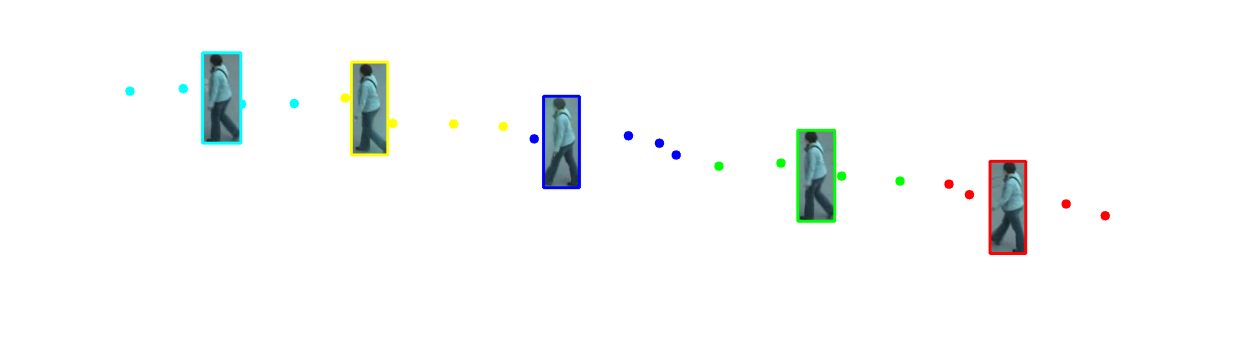

In [139]:
scale = 5
# video_shape = ((720+200)*scale, (576+200)*scale) 
video_shape = ((720)*scale, (576)*scale) 

img = np.ones((video_shape[1],video_shape[0],3), np.uint8)*255

img        = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
alpha      = img[:,:,3]
alpha      = alpha*0
img[:,:,3] = alpha

reset_color_global()

plotTrackletsInfo = list()
for key in sorted(genDictBestSelect.keys()): 
    list_bestGallery  = genDictBestSelect[key]
    for i_dict in list_bestGallery:
        plotTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])

for key in genDictSelect: 
    list_dictGallery = genDictSelect[key]
    allTrackletsInfo = list()
    for i_dict in list_dictGallery:
        allTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])

    img = plot_tracklet_v2( img, 
                              colors_alpha,
                              plotTrackletsInfo = plotTrackletsInfo, 
                              allTrackletsInfo  = allTrackletsInfo, 
                              step              = 4, 
                              scale             = scale,
                              thickness         = 4,
                              radiusPoint       = 8,
                              colorBB           = True,
                              imageLess         = False,
                              trackletColorBB   = True,
                              trackletlImageLess= True,
                              trackletInFront   = True,
                              trackletInFrontColorBB = True,
                              trackletBB_to_point    =  True,)

        
        
plt.figure(figsize=(16,16))
# plt.imshow(img)

img_cropped = img[650:1200,0:2000, :] # Y,X,Z
# img_cropped = img# Y,X,Z

plt.imshow(img_cropped)
# plt.title('my picture')
plt.axis('off')

plt.savefig(os.path.join(path_save,'tracklet_w_best_bb.png'), dpi=save_dpi, transparent=True,bbox_inches='tight', pad_inches=0)

plt.show()




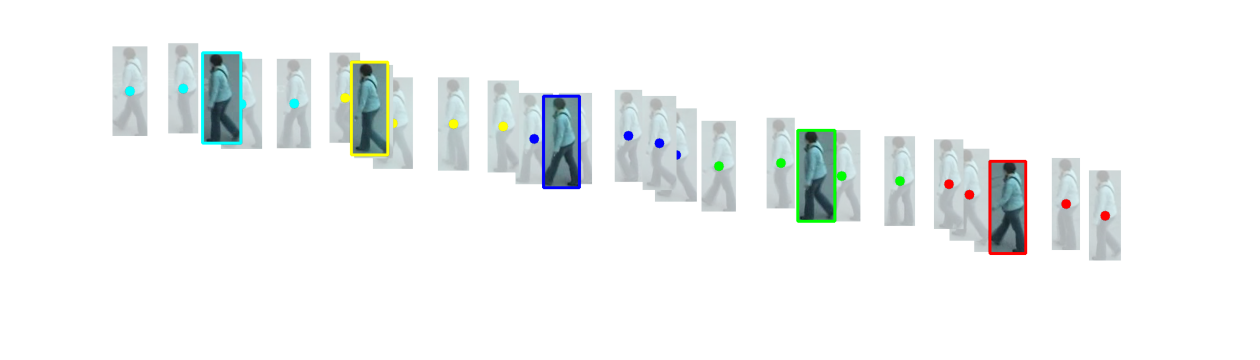

In [140]:
scale = 5
# video_shape = ((720+200)*scale, (576+200)*scale) 
video_shape = ((720)*scale, (576)*scale) 

img = np.ones((video_shape[1],video_shape[0],3), np.uint8)*255

img        = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
alpha      = img[:,:,3]
alpha      = alpha*0
img[:,:,3] = alpha

reset_color_global()

plotTrackletsInfo = list()
for key in sorted(genDictBestSelect.keys()): 
    list_bestGallery  = genDictBestSelect[key]
    for i_dict in list_bestGallery:
        plotTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])

for key in genDictSelect: 
    list_dictGallery = genDictSelect[key]
    allTrackletsInfo = list()
    for i_dict in list_dictGallery:
        allTrackletsInfo.append([os.path.join(i_dict['path'],i_dict['name']),i_dict['bbox']])
         
#     plot_tracklet(img, 
#                   allTrackletsInfo = allTrackletsInfo, 
#                   step             = 3, 
#                   scale            = scale, 
#                   colorBB          = False)
    
        
        
    img = plot_tracklet_v2( img, 
                            colors_alpha,
                          plotTrackletsInfo = plotTrackletsInfo, 
                          allTrackletsInfo  = allTrackletsInfo, 
                          step              = 4, 
                          scale             = scale,
                          thickness         = 4,
                          radiusPoint       = 8,
                          colorBB           = True,
                          imageLess         = True, #False
                          trackletColorBB   = True,
                          trackletlImageLess= True,
                          trackletInFront   = True,
                          trackletInFrontColorBB = True,
                          trackletBB_to_point    =  True,
                          spotlight_iALL          = 90)
    

        
        
plt.figure(figsize=(16,16))
# plt.imshow(img)

img_cropped = img[650:1200,0:2000, :] # Y,X,Z
# img_cropped = img# Y,X,Z


plt.imshow(img_cropped)
# plt.title('my picture')
plt.axis('off')

plt.savefig(os.path.join(path_save,'tracklet_w_best_bb_example.png'), dpi=save_dpi, transparent=True,bbox_inches='tight', pad_inches=0)

plt.show()


